## 개 품종 딥러닝 (대형견 한정)
- OpenCV 팀 프로젝트
- 데이터 출처 : https://www.kaggle.com/datasets/amandam1/120-dog-breeds-breed-classification

개발 포인트
- ImageFolder
- Transforms
- DataLoader
- WeightedRandomSampler
- CNN

(1) 데이터 준비

In [1]:
import torch

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torchvision.models import resnet18, ResNet18_Weights

import numpy as np

C:\Users\kdp\.conda\envs\Torch_38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
preprocessing = transforms.Compose([
    transforms.Resize((32, 32)),    # 32x32 크기
    transforms.ToTensor()
])

(2) Dataset 생성 (훈련용, 검증용)

In [92]:
### 데이터셋 생성
### img_root = './image'로 잡으면 BIG 폴더 안의 각 개들에 대한 클래스를 못 얻음
# img_root = './image/BIG'
# img_root = './modified/BIG'
img_root = './Images-resized'

imgDS = ImageFolder(root=img_root, transform=preprocessing)

In [93]:
type(imgDS), len(imgDS)

(torchvision.datasets.folder.ImageFolder, 1297)

In [94]:
print(f'img 타입 : {type(imgDS[0][0])}, label 타입 : {type(imgDS[0][1])}')

img 타입 : <class 'torch.Tensor'>, label 타입 : <class 'int'>


In [95]:
print(f'img shape : {imgDS[0][0].shape}')

img shape : torch.Size([3, 32, 32])


In [96]:
len(imgDS.classes)

7

In [97]:
imgDS.class_to_idx

{'Chihuahua': 0,
 'Maltese_dog': 1,
 'Pekinese': 2,
 'Shih-Tzu': 3,
 'beagle': 4,
 'bluetick': 5,
 'papillon': 6}

In [98]:
np.array(imgDS.imgs)[:5]

array([['./Images-resized\\Chihuahua\\n02085620_10074.png', '0'],
       ['./Images-resized\\Chihuahua\\n02085620_10131.png', '0'],
       ['./Images-resized\\Chihuahua\\n02085620_10621.png', '0'],
       ['./Images-resized\\Chihuahua\\n02085620_1073.png', '0'],
       ['./Images-resized\\Chihuahua\\n02085620_10976.png', '0']],
      dtype='<U48')

In [99]:
# ImageFolder로 읽어왔을 때 imgs에 저장되는 문자열 형식 파악
filename = np.array(imgDS.imgs)[0, 0]
print(filename)
filename.count('\\')

./Images-resized\Chihuahua\n02085620_10074.png


2

In [100]:
# 'BIG' 디렉터리에 해당하는 인덱스 추출
# big_indices = [i for i, (_, label) in enumerate(imgDS.samples) if imgDS.classes[label] == 'BIG']

In [101]:
# Subset 생성 ('BIG'에 해당하는 사진만)
# bigSS = Subset(imgDS, big_indices)
# len(bigSS)

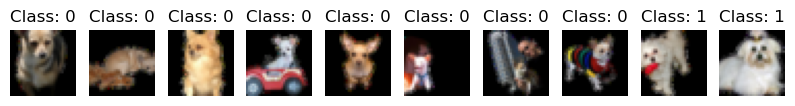

In [103]:
### 데이터 확인 (시각화)
import matplotlib.pyplot as plt
import numpy as np

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(imgDS[i*20][0], (1, 2, 0)))    # (C, H, W) -> (H, W, C)로 변환
    plt.title('Class: ' + str(imgDS[i*20][1]))

In [104]:
### 이미지와 레이블을 ndarray로 변환
### preprocessing 없이 ImageFolder 생성해서 아래 코드 실행하면 RAM 메모리 부족으로 MemoryError 발생
### MemoryError: Unable to allocate 488. KiB for an array with shape (500, 333, 3) and data type uint8
images = []
labels = []

for img, label in imgDS:    # img : <class 'PIL.Image.Image'>, label : <class 'int'>
    images.append(np.array(img))      # PIL.Image.Image 객체 -> ndarray 변환 가능
    labels.append(np.array(label))
len(images), len(labels)

(1297, 1297)

In [105]:
imagesNP = np.array(images)
labelsNP = np.array(labels)

print(f'imagesNP shape : {imagesNP.shape}, labelsNP shape : {labelsNP.shape}')

imagesNP shape : (1297, 3, 32, 32), labelsNP shape : (1297,)


In [106]:
### => train, test 데이터셋으로 나누기
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(imagesNP, labelsNP, test_size=0.2, stratify=labels, random_state=42)
print(f'x_train : {x_train.shape} {x_train.ndim}D')     # 4D
print(f'y_train : {y_train.shape} {y_train.ndim}D')     # 1D

x_train : (1037, 3, 32, 32) 4D
y_train : (1037,) 1D


In [107]:
"""### TesnorDataset에 적용하기 위해, y값을 1D -> 2D로 변환
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

print(f'y_train: {y_train.shape} {y_train.ndim}D')
print(f'y_test : {y_test.shape} {y_test.ndim}D')"""

"### TesnorDataset에 적용하기 위해, y값을 1D -> 2D로 변환\ny_train = np.expand_dims(y_train, axis=1)\ny_test = np.expand_dims(y_test, axis=1)\n\nprint(f'y_train: {y_train.shape} {y_train.ndim}D')\nprint(f'y_test : {y_test.shape} {y_test.ndim}D')"

In [108]:
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [109]:
x_trainTS = torch.FloatTensor(x_train)
y_trainTS = torch.LongTensor(y_train)

x_testTS = torch.FloatTensor(x_test)
y_testTS = torch.LongTensor(y_test)

In [110]:
"""x_trainTS = torch.IntTensor(x_train)
y_trainTS = torch.IntTensor(y_train)

x_testTS = torch.IntTensor(x_test)
y_testTS = torch.IntTensor(y_test)"""

'x_trainTS = torch.IntTensor(x_train)\ny_trainTS = torch.IntTensor(y_train)\n\nx_testTS = torch.IntTensor(x_test)\ny_testTS = torch.IntTensor(y_test)'

In [111]:
trainDS = TensorDataset(x_trainTS, y_trainTS)
testDS = TensorDataset(x_testTS, y_testTS)

In [112]:
len(trainDS), len(testDS)

(1037, 260)

In [113]:
# 클래스별 샘플 수 계산
import os

def file_count_in_dir(path):
    """ path : 대장 폴더 주소 """
    if not path.endswith('/'):
        path += '/'
    
    file_count = dict()
    
    datalist = os.listdir(path)
    for data in datalist:
        if os.path.isdir(path + data):
            sub_datalist = os.listdir(path + data)
            file_count[path + data] = len(sub_datalist)
    return file_count

In [55]:
# file_count = file_count_in_dir(img_root)
# file_count2 = {key.split('/')[-1]: value for key, value in file_count.items()}
# file_count3 = {key.split('_')[0]: value for key, value in file_count2.items()}
# print(file_count3)

In [256]:
# class_names = imgDS.class_to_idx
# class_names

In [257]:
# class_names = {key.split('_')[0]: value for key, value in class_names.items()}
# class_names

In [258]:
# class_count = [file_count3[key] for key, value in class_names.items()]
# print(class_count)

In [259]:
"""### Sampler에서 사용할 가중치 생성
total_image_count = len(class_count)
# weights = [class_count / total_image_count for class_count in class_count]
weights = []
for i, v in enumerate(class_count):
    weights.extend([1 / v] * v)
print(len(weights))"""

'### Sampler에서 사용할 가중치 생성\ntotal_image_count = len(class_count)\n# weights = [class_count / total_image_count for class_count in class_count]\nweights = []\nfor i, v in enumerate(class_count):\n    weights.extend([1 / v] * v)\nprint(len(weights))'

(3) DataLoader 생성 (훈련용, 검증용)

In [114]:
BATCH_SIZE = 64

In [115]:
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE)
testDL = DataLoader(testDS, batch_size=BATCH_SIZE)

for idx, (img, label) in enumerate(trainDL):
    if idx > 2: break
    # print(img.shape, label.shape, label.bincount())
    print(img.shape, label.shape)       # img : 4D, label : 2D
    # print(label)

print(f'trainDL batch 개수 : {len(trainDL)}')
print(f'testDL batch 개수 : {len(testDL)}')

torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
trainDL batch 개수 : 17
testDL batch 개수 : 5


(4) cnn 모델 만들기

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from torchinfo import summary

In [117]:
imgDS[0][0].shape

torch.Size([3, 32, 32])

In [118]:
conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)  # 피처 8개 뽑겠다.
conv1

Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [119]:
output1 = conv1(imgDS[0][0])
output1.shape

torch.Size([8, 32, 32])

In [120]:
pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
pool

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [121]:
output2 = pool(output1)
output2.shape

torch.Size([8, 16, 16])

In [122]:
conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
conv2

Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [123]:
output3 = pool(output2)
output3.shape

torch.Size([8, 8, 8])

In [124]:
conv3 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
conv3

Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [125]:
output4 = conv3(output3)
output4.shape

torch.Size([16, 8, 8])

In [126]:
output5 = pool(output4)
output5.shape

torch.Size([16, 4, 4])

In [129]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(16 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, len(imgDS.classes))
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 16 * 8 * 8)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # x = F.log_softmax(x)  # CrossEntropy()에 중복
        return x

(5) CNN 학습하기

In [130]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 1000

# model = cnn_model().to(DEVICE)
model = CNN().to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=7, bias=True)
)


In [131]:
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx:2d}]\tTrain Loss: {loss.item():.6f}")

In [132]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [133]:
## train에 쓰는 데이터와 test에 쓰는 데이터를 다르게 둬야 하는데, 지금은 그렇게 하지 못 함.
test_loss_list, test_accuracy_list = [], []

for epoch in range(1, EPOCHS + 1):
    
    train(epoch, model, trainDL, optimizer, log_interval = 50)
    test_loss, test_accuracy = evaluate(model, testDL)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

Train Epoch: 1 [ 0]	Train Loss: 1.970227

[EPOCH: 1], 	Test Loss: 0.0369, 	Test Accuracy: 21.54 % 

Train Epoch: 2 [ 0]	Train Loss: 1.921422

[EPOCH: 2], 	Test Loss: 0.0360, 	Test Accuracy: 20.77 % 

Train Epoch: 3 [ 0]	Train Loss: 1.849513

[EPOCH: 3], 	Test Loss: 0.0350, 	Test Accuracy: 23.85 % 

Train Epoch: 4 [ 0]	Train Loss: 1.766271

[EPOCH: 4], 	Test Loss: 0.0344, 	Test Accuracy: 28.08 % 

Train Epoch: 5 [ 0]	Train Loss: 1.696184

[EPOCH: 5], 	Test Loss: 0.0341, 	Test Accuracy: 28.46 % 

Train Epoch: 6 [ 0]	Train Loss: 1.644004

[EPOCH: 6], 	Test Loss: 0.0339, 	Test Accuracy: 28.46 % 

Train Epoch: 7 [ 0]	Train Loss: 1.597457

[EPOCH: 7], 	Test Loss: 0.0338, 	Test Accuracy: 28.85 % 

Train Epoch: 8 [ 0]	Train Loss: 1.553417

[EPOCH: 8], 	Test Loss: 0.0337, 	Test Accuracy: 31.15 % 

Train Epoch: 9 [ 0]	Train Loss: 1.513896

[EPOCH: 9], 	Test Loss: 0.0336, 	Test Accuracy: 31.15 % 

Train Epoch: 10 [ 0]	Train Loss: 1.487973

[EPOCH: 10], 	Test Loss: 0.0337, 	Test Accuracy: 31.15 % 

KeyboardInterrupt: 

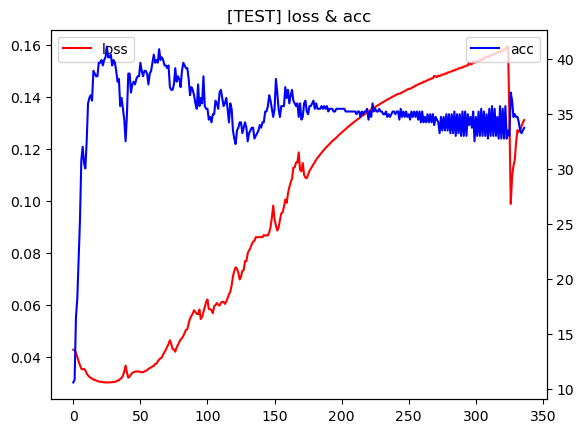

In [91]:
### 테스트 Loss와 Acc 시각화
fig, ax1 = plt.subplots()
ax1.plot(test_loss_list, label='loss', color='red')

ax2 = ax1.twinx()
ax2.plot(test_accuracy_list, label='acc', color='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('[TEST] loss & acc')
plt.show()

In [306]:
import os, sys
from rembg import remove
from PIL import Image

print(os.getcwd())

def img_rembg(img_path, modified_path):
    files = os.listdir(img_path)    # 파일명 리스트 (list)
    
    if not os.path.exists(modified_path):
        os.makedirs(modified_path)  # resize 이미지가 저장될 폴더가 없을 경우 생성
    
    for file in files:
        img = Image.open(img_path + '/' + file)           # <class 'PIL.JpegImagePlugin.JpegImageFile'>
        img = img.convert('RGBA')
        img = remove(img)
        img.save(modified_path + '/' + file.replace('jpg', 'png'))

C:\Users\kdp\PycharmProjects\KDT_09_OpenCV\WORK_OPENCV\WORK_240326_TEAM_PROJECT


In [ ]:
original_path = './image/BIG'
modified_path = './modified/BIG'
for folder in os.listdir(original_path):
    img_rembg(original_path + '/' + folder, modified_path + '/' + folder)

In [310]:
dog_path = './image/BIG/AfghanHound_big'
modified_path = './modified'
img_rembg(dog_path, modified_path)

In [312]:
print('abc')

abc
